**Christian Gauthier Coursework**

*I worked and submitted alone*

*Student Number: 33683676*

**Overall Problem:**

Energy efficiency regression problem to determine the heating load of buildings. One output label defined as Y which acts as the target from the 9 input predictors (X0-X8).

Dataset contains 768 values, however 10 of which contain NAN values (X3 column). To overcome this issue, the values have been imputed where needed. Data is split at a 70:30 ratio to create training and testing datasets. 

**Measure Of Success:**

Within the development of the models, the main measure of success is MAE (Mean Absolute Error), this is because of the nature of the regression problem at hand. The MAE shows overall success of the model with the target value being as close to zero as possible. After development of all the models, the 2 best models with the lowest score of MAE gain access to testing on the test dataset.



**Data Inspection And Visualisation**

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('datcw_na.csv')
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,C3,1.19,622.55,NaN,89.31,7.00,1.98,0.0,0.0,15.55
1,C1,1.19,622.55,323.40,109.15,7.70,3.00,0.0,0.0,15.55
2,C1,0.88,463.05,291.06,99.23,5.67,4.40,0.0,0.0,15.55
3,C2,0.79,509.36,291.06,121.28,6.30,4.05,0.0,0.0,15.55
4,C1,0.89,507.15,385.39,121.28,7.70,2.00,0.0,0.0,20.84


X0:  Category of the building

X1: Relative Compactness

X2: Surface Area

X3: Wall Area

X4: Roof Area

X5: Overall Height

X6: Orientation

X7: Glazing Area

X8: Glazing Area Distribution

Y: Heating Load

**Data Visualization**

In [59]:
from sklearn.model_selection import train_test_split

#Split dataset into test and train
train_df,test_df = train_test_split(df, test_size=0.3, shuffle=False)

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_18736\1541063517.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(),vmin=-1,vmax=1,cmap="coolwarm",annot=True) #show the data as a heatmap


<AxesSubplot: >

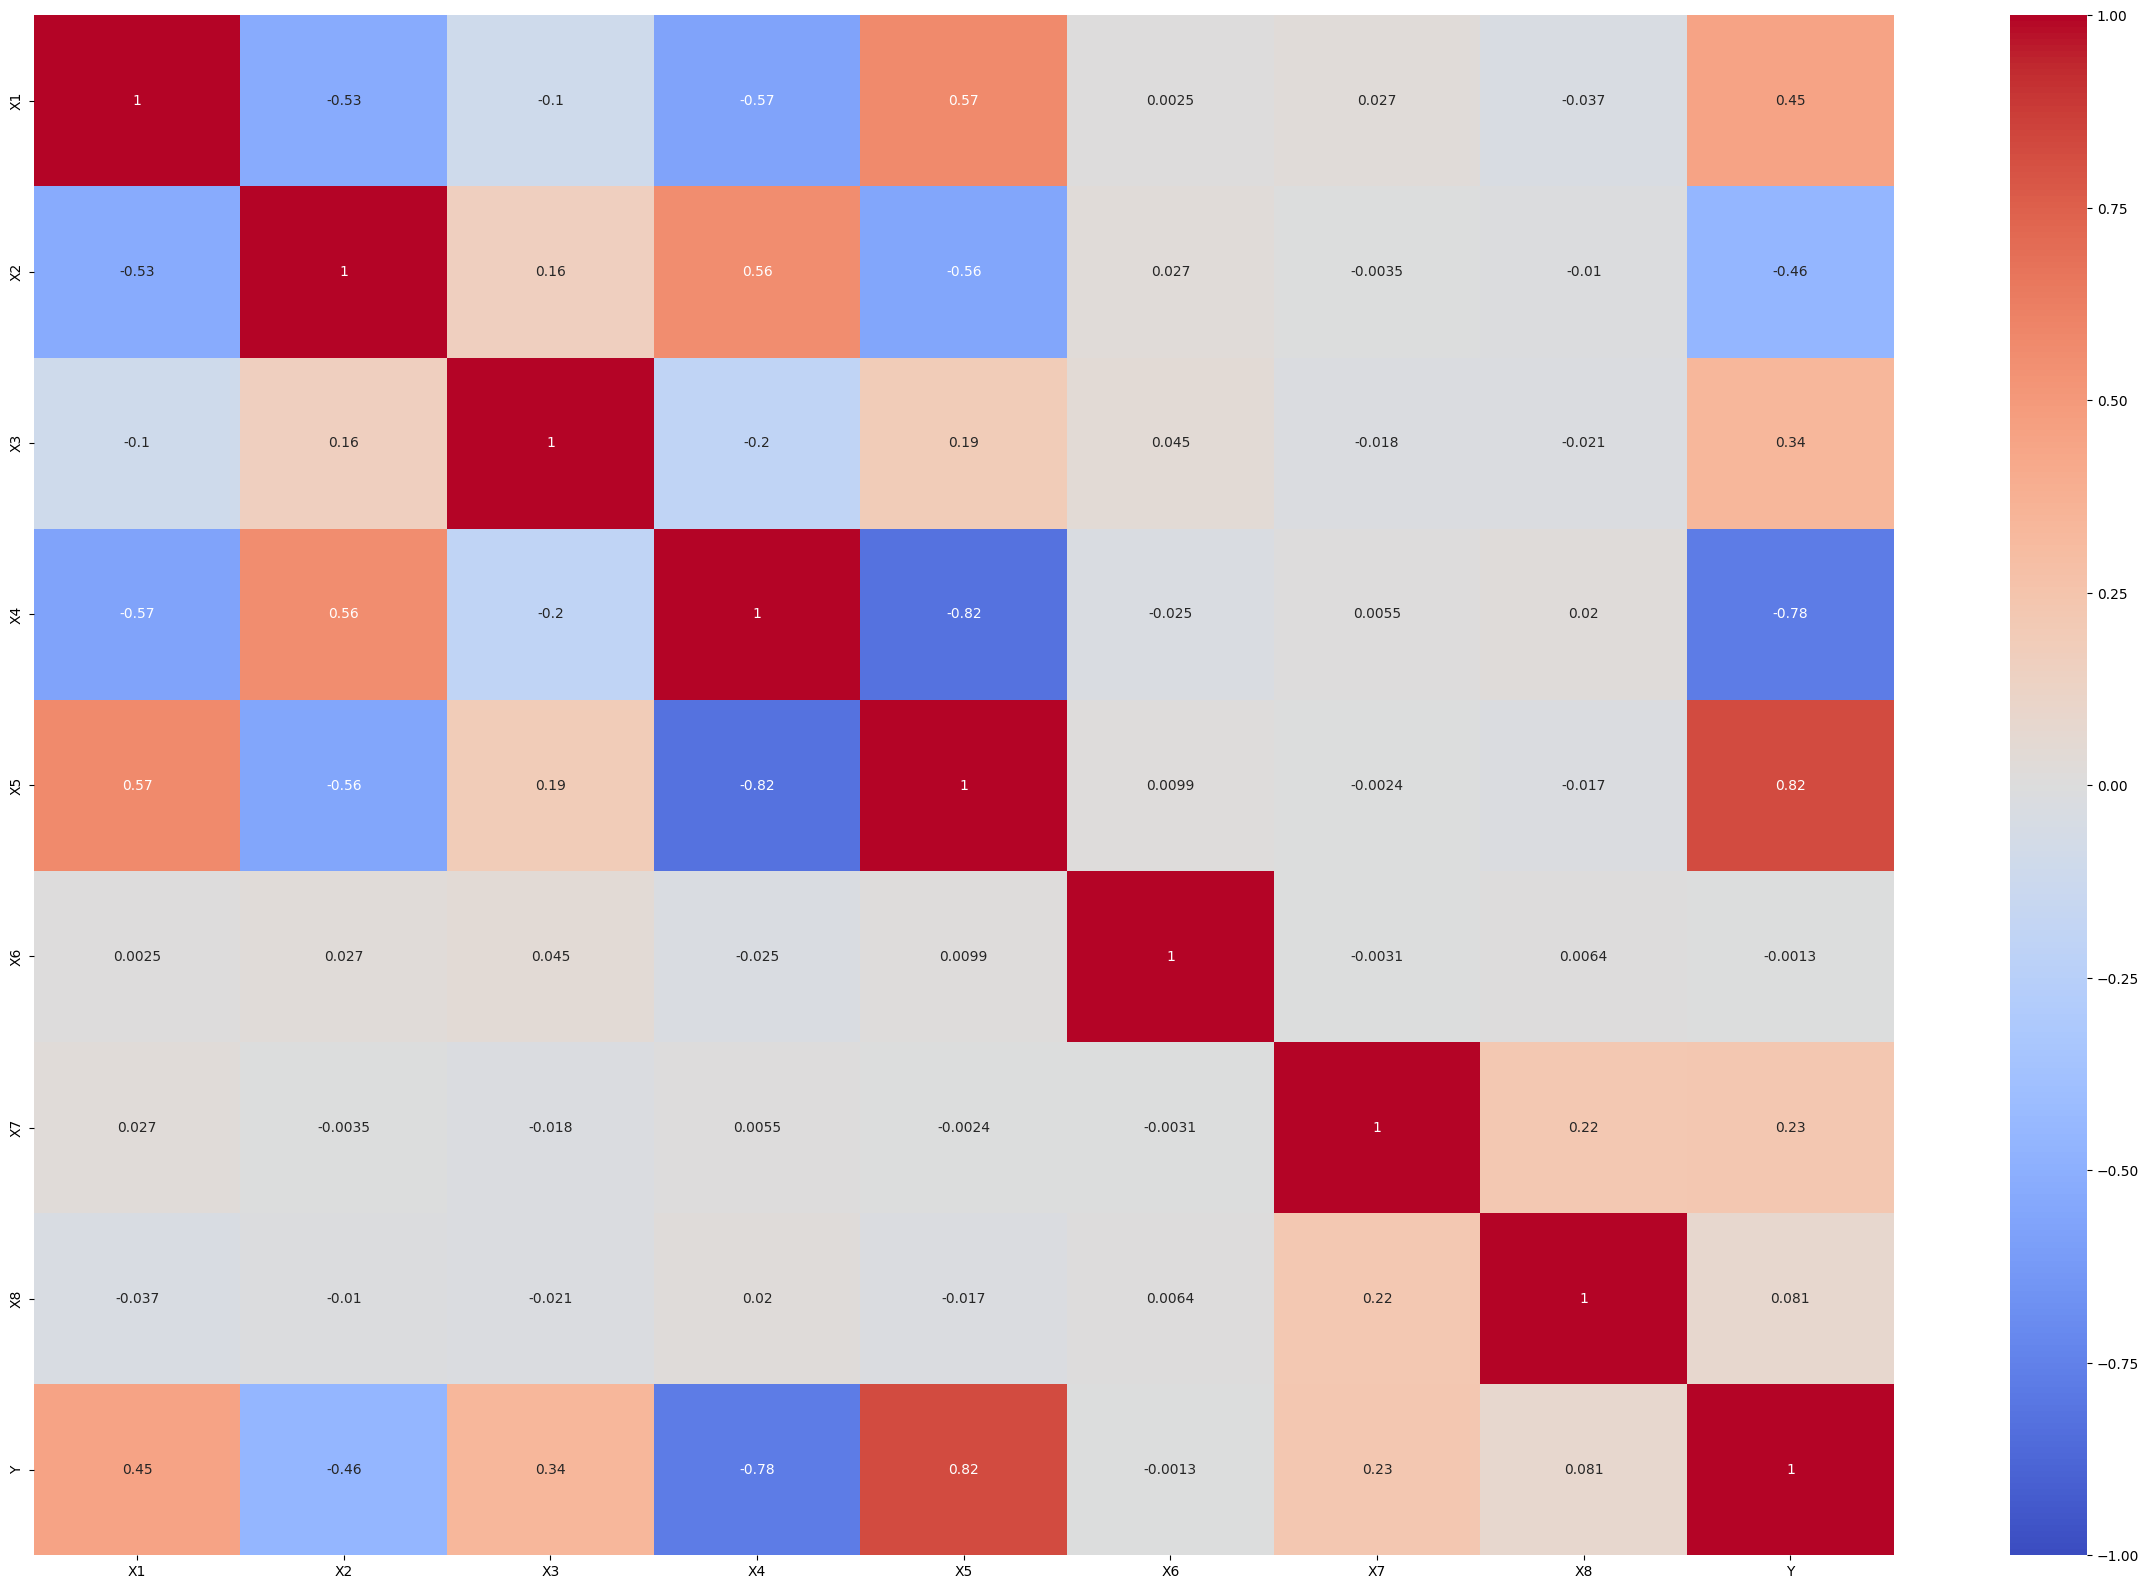

In [60]:
#return a description of the dataframe 
train_df.describe() 

#create figure of heatmap
plt.figure(figsize=(30,20)) 
sns.heatmap(train_df.corr(),vmin=-1,vmax=1,cmap="coolwarm",annot=True) #show the data as a heatmap

*Heatmap*

The utilization of a heatmap facilitates the visualization of correlations among variables, thereby displaying the relative significance of predictors with respect to the outcome, namely, the heating load (Y), in an image format. The heatmap analysis allows for the identification of variables that exhibit the highest correlations with the output, with the order of importance being x5, x4, x2, x1, x3, x7, x8, and x6.

array([[<AxesSubplot: title={'center': 'X1'}>,
        <AxesSubplot: title={'center': 'X2'}>,
        <AxesSubplot: title={'center': 'X3'}>],
       [<AxesSubplot: title={'center': 'X4'}>,
        <AxesSubplot: title={'center': 'X5'}>,
        <AxesSubplot: title={'center': 'X6'}>],
       [<AxesSubplot: title={'center': 'X7'}>,
        <AxesSubplot: title={'center': 'X8'}>,
        <AxesSubplot: title={'center': 'Y'}>]], dtype=object)

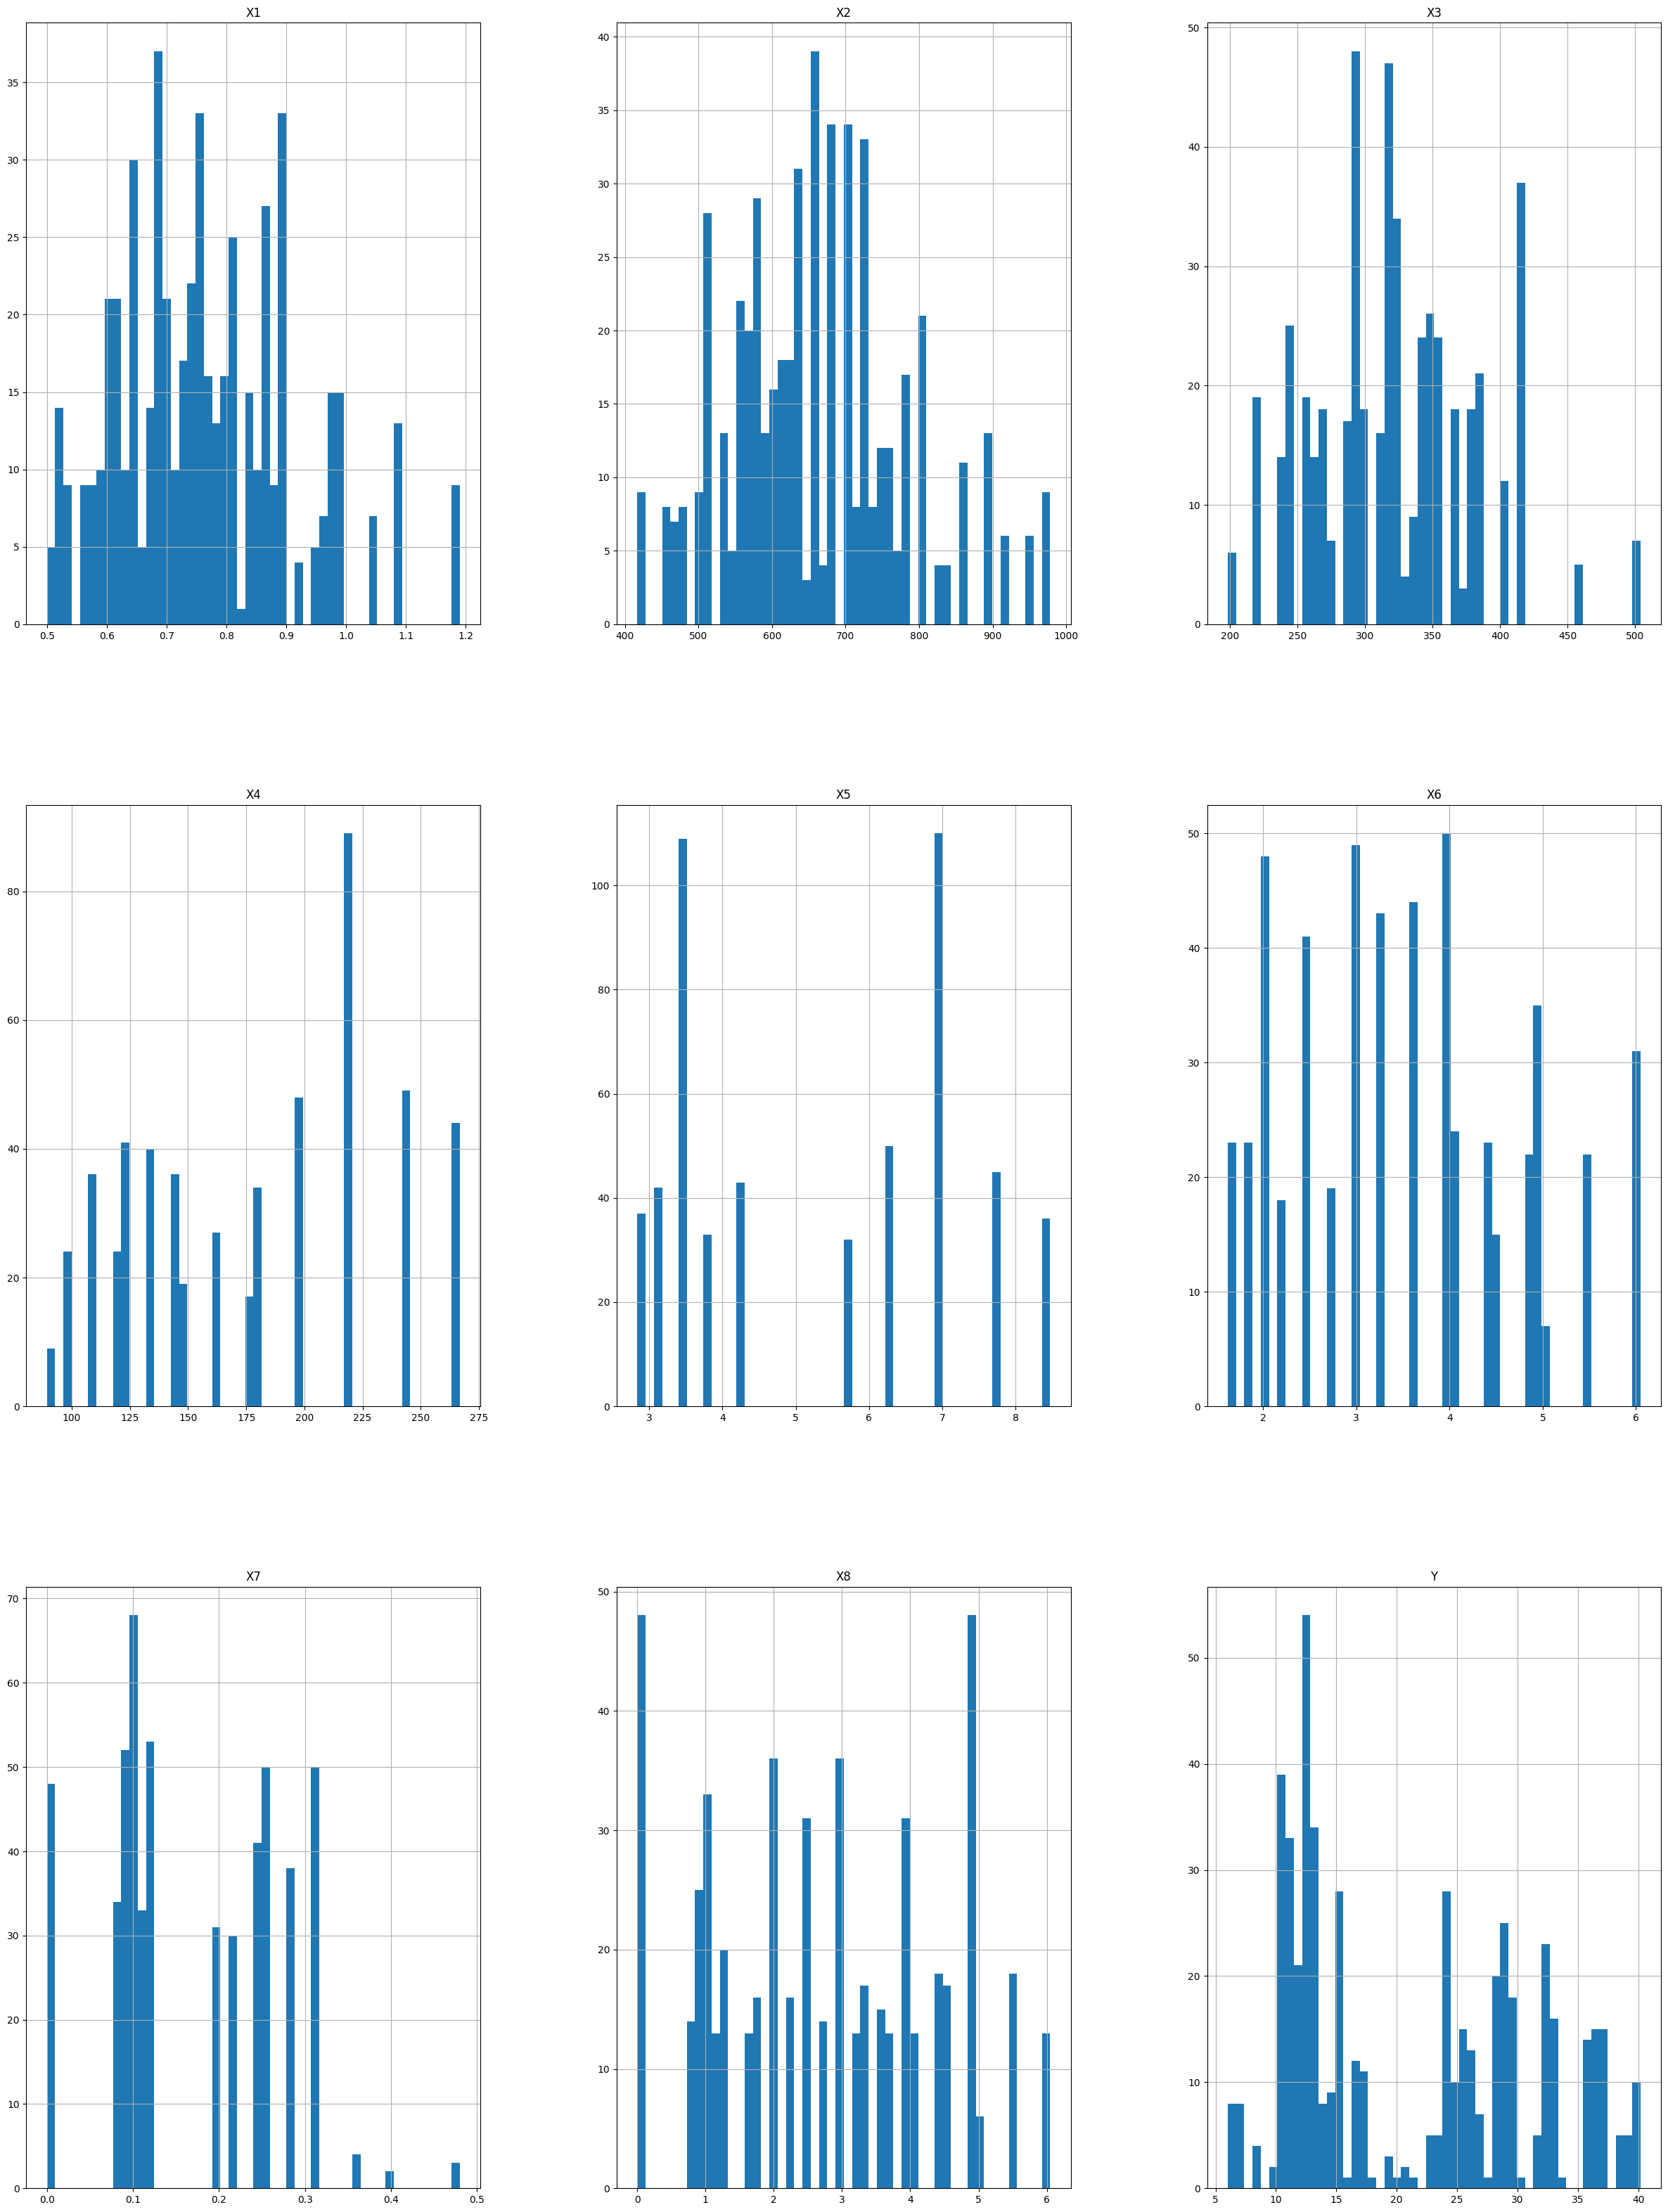

In [61]:
#Histogram plot of dataset
train_df.hist(bins=50,figsize=(30,40))

*Histogram*

The histogram is a graphical representation that provides insight into the distribution of data for each variable. The analysis of the dataset reveals that only a limited number of variables (X1, X2, X3, and X5) exhibit a clear pattern, with a smooth and easily identifiable distribution compared to the remaining variables. Notably, the distributions indicate the absence of any identifiable outliers that require consideration before use within the models.

**Data Pre-Processing**

In [62]:
from sklearn.impute import KNNImputer
#Impute values in X3 column by using KNN

imputer = KNNImputer(n_neighbors=5)

#Get values from the X3 column
x3 = df[['X3']]  
X3_imputed = pd.DataFrame(imputer.fit_transform(x3), columns=x3.columns)
df['X3'] = X3_imputed['X3']

In [63]:
#No more nan values
print(df['X3'].isna().any())

False


In [64]:
#Create predictor and label groups from dataset
predictors = df["Y"].copy()
labels = df.iloc[:, :-1]

In [65]:
#Split into train and test at 70:30 ratio
x_train, x_test, y_train, y_test = train_test_split(labels, predictors, test_size=0.3, shuffle=False)

In [66]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(537, 9)
(537,)
(231, 9)
(231,)


In [67]:
print(x_train.head)

<bound method NDFrame.head of      X0    X1      X2          X3      X4    X5    X6    X7    X8
0    C3  1.19  622.55  321.102527   89.31  7.00  1.98  0.00  0.00
1    C1  1.19  622.55  323.400000  109.15  7.70  3.00  0.00  0.00
2    C1  0.88  463.05  291.060000   99.23  5.67  4.40  0.00  0.00
3    C2  0.79  509.36  291.060000  121.28  6.30  4.05  0.00  0.00
4    C1  0.89  507.15  385.390000  121.28  7.70  2.00  0.00  0.00
..   ..   ...     ...         ...     ...   ...   ...   ...   ...
532  C2  0.81  619.85  257.980000   99.23  8.47  2.42  0.36  0.90
533  C1  1.09  619.85  315.320000  110.25  6.93  3.00  0.36  0.99
534  C1  1.09  507.15  315.320000   99.23  6.93  3.60  0.48  0.81
535  C1  0.89  557.86  350.350000  148.23  5.67  4.95  0.40  0.90
536  C3  0.77  529.20  264.600000  145.53  8.47  1.98  0.48  1.00

[537 rows x 9 columns]>


*Scale the data*

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#Select numerical features in the predictors
numeric_features = ['X1','X2','X3','X4','X5','X6','X7','X8']
numeric_transformer = Pipeline([
    ('std_scaler', StandardScaler())
])

#Select categorical features
categorical_features = ['X0']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

#Combine into a column transformation on whole groups within dataset
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

#Apply the transformations based on the train dataset
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

In [69]:
#Define new standard scaler for Y values
scaler = StandardScaler()

#Reshape the outputs for use in models
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [70]:
#Trains have increased by 2 because of the one hot encoding
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(537, 11)
(537, 1)
(231, 11)
(231, 1)


**Model Training And Optimisation**

Now that the data has been processed and is ready for use within the models. The models being used within this study will be Linear Regression, Elastic Net Regression and densely layered Neural Network. Models will be ran through a Kfold validation method in which the average MAE of the models will be used to determine each performance, the models with the lowest values moving to the final stage of having access to the test dataset. 

Hyperparameter tuning will be done via a gridsearch cross-validation method where all parameter configurations are attempted. 

**Kfolding Method:**

For testing the models I have implemented a K-fold Cross validation method that will take in each individual model and split the train dataset into 4 equal sized chunks. This method will be used alongside GridSearchCV to find the optimal hyperparameters. This method creates a nested K-fold cross validation system in attempts to optimize the models resulting MAE value. 

In [71]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from numpy import mean,std,absolute
from sklearn.model_selection import GridSearchCV

def kfolder(modeltype):
    K = 4
    num_val_samples = len(x_train) // K
    all_scores = []

    for i in range(K):
        print('processing fold', i)
        
        #Prepare the validation data: data from partition i
        a, b = i * num_val_samples, (i + 1) * num_val_samples
        val_data = x_train[a : b]
        val_targets = y_train[a : b]
        
        #Prepare the training data: data from all other partitions
        partial_train_data = np.concatenate([x_train[:a], x_train[b:]], axis=0)
        partial_train_targets = np.concatenate([y_train[:a], y_train[b:]], axis=0)
        
        #Fit the classifier to the training data
        modeltype.fit(partial_train_data, partial_train_targets)

        #Make predictions on the test data
        y_pred = modeltype.predict(val_data)
        all_scores.append(mean_absolute_error(y_pred,val_targets))
    return all_scores

*Linear Regression*

In [72]:
from sklearn.linear_model import LinearRegression

#Define the model
lin_reg = LinearRegression()

#Run model through Kfold
lin_reg_results = kfolder(lin_reg)

#Average score over K-Fold
print('Kfold MAE results: ' + str(lin_reg_results))
print('Mean Kfold MAE: ' + str(np.mean(lin_reg_results)))


processing fold 0
processing fold 1
processing fold 2
processing fold 3
Kfold MAE results: [0.3950573758305541, 0.34617614323312634, 0.3104117628845194, 0.388049018980243]
Mean Kfold MAE: 0.3599235752321107


*Elastic Net*

In [74]:
from sklearn.linear_model import ElasticNet

#define the model
el_net = ElasticNet()

#run the un-tuned model through kfold to see what scores acheived
el_net_results = kfolder(el_net)

#Average score over K-Fold
print('Kfold MAE results: ', el_net_results)
print('Mean Kfold MAE: ', np.mean(el_net_results))

processing fold 0
processing fold 1
processing fold 2
processing fold 3
Kfold MAE results:  [0.7200696848057184, 0.6171228274025328, 0.705044148595385, 0.7658847916226486]
Mean Kfold MAE:  0.7020303631065712


In [14]:
#Tune the model through the use of a gridsearch to find the best alpha and l1 ratio hyperparams
param_grid = {'alpha': [0.05, 0.1, 0.3, 0.5, 0.75, 0.8, 0.9, 1.0, 2.0, 5.0],
              'l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.45, 0.5, 0.7, 0.9]}

grid_search_el = GridSearchCV(estimator=el_net, param_grid=param_grid, cv=20)
grid_search_el.fit(x_train, y_train)

GridSearchCV(cv=20, estimator=ElasticNet(),
             param_grid={'alpha': [0.05, 0.1, 0.3, 0.5, 0.75, 0.8, 0.9, 1.0,
                                   2.0, 5.0],
                         'l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.45,
                                      0.5, 0.7, 0.9]})

In [15]:
#Best parameter values
print('Best hyperparameters: ', grid_search_el.best_params_)

Best hyperparameters:  {'alpha': 0.05, 'l1_ratio': 0.2}


In [78]:
#Define new model on best params
el_net_best = ElasticNet(alpha=0.05, l1_ratio=0.2)

#Run through kfold
el_net_best_results = kfolder(el_net_best)

#Average score over K-Fold
print('Kfold MAE results: ', el_net_best_results)
print('Mean Kfold MAE: ', np.mean(el_net_best_results))

processing fold 0
processing fold 1
processing fold 2
processing fold 3
Kfold MAE results:  [0.4046382531376124, 0.3420140998678387, 0.30904179539358023, 0.38919646459886476]
Mean Kfold MAE:  0.36122265324947406


*Dense NN*

In [81]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [37]:
# Define the model
def build_model(learning_rate, momentum, activation, hidden_layer_size, kernel_regularizer):
    model = keras.models.Sequential([
        layers.Dense(hidden_layer_size, activation=activation, input_shape=(x_train.shape[1],), kernel_regularizer=kernel_regularizer),
        layers.Dense(hidden_layer_size, activation=activation, input_shape=(x_train.shape[1],), kernel_regularizer=kernel_regularizer),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [38]:
#Allow keras model to use scikit-learn estimator
model = KerasRegressor(build_fn=build_model, verbose=0)

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_14748\2623280333.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, verbose=0)


In [39]:
#Define the hyperparamters and what values best to use 
param_grid = {
    'learning_rate': [0.01, 0.015, 0.0175, 0.02, 0.025, 0.03, 0.05],
    'momentum': [0.01, 0.015, 0.0175, 0.02, 0.025, 0.03, 0.05, 0.1],
    'activation': ['relu', 'tanh'],
    'hidden_layer_size': [4, 8, 16, 32, 64],
    'kernel_regularizer': [None, keras.regularizers.l1(0.01), keras.regularizers.l2(0.01)]
}

#Create scoring function 
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [40]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=4), scoring=scorer, verbose=1)
grid_search.fit(x_train, y_train)

Fitting 4 folds for each of 1680 candidates, totalling 6720 fits


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000154850B44F0>,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_size': [4, 8, 16, 32, 64],
                         'kernel_regularizer': [None,
                                                <keras.regularizers.L1 object at 0x00000154850B4340>,
                                                <keras.regularizers.L2 object at 0x00000154850B4610>],
                         'learning_rate': [0.01, 0.015, 0.0175, 0.02, 0.025,
                                           0.03, 0.05],
                         'momentum': [0.01, 0.015, 0.0175, 0.02, 0.025, 0.03,
                                      0.05, 0.1]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [42]:
#Print best parameters
print('Best hyperparameters:', grid_search.best_params_)
print('Best mean absolute error:', np.abs(grid_search.best_score_))

Best hyperparameters: {'activation': 'tanh', 'hidden_layer_size': 8, 'kernel_regularizer': <keras.regularizers.L2 object at 0x00000154850B4610>, 'learning_rate': 0.02, 'momentum': 0.01}
Best mean absolute error: 0.315144438242371


In [79]:
#Function to find best model hyperparams
def best_model():
    model = keras.models.Sequential([
        layers.Dense(8, activation='tanh', input_shape=(x_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(8, activation='tanh', input_shape=(x_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dense(1)
    ])
    optimizer = keras.optimizers.RMSprop(learning_rate=0.02, momentum=0.01)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [82]:
#Create new model based on best params
nn_model = best_model()

In [84]:
#run the un-tuned model through kfold to see what scores acheived
nn_results = kfolder(nn_model)

#Average score over K-Fold
print('Kfold MAE results: ', nn_results)
print('Mean Kfold MAE: ', np.mean(nn_results))

processing fold 0
5/5 [==============================] - 0s 2ms/step
processing fold 1
5/5 [==============================] - 0s 2ms/step
processing fold 2
5/5 [==============================] - 0s 1ms/step
processing fold 3
5/5 [==============================] - 0s 2ms/step
Kfold MAE results:  [0.413196783819332, 0.26087257463417696, 0.24206768758040453, 0.2693479361170719]
Mean Kfold MAE:  0.29637124553774635


**Further Model Selection**

Model Results:

| MODEL      | AVG MAE |
|------------|---------|
| Linear     | 0.3599  |
| Eastic Net | 0.3612  |
| Dense NN   | 0.2963  |

The models were fitted and hyperparameters were tuned using grid search with cross-validation. The linear regression model was fitted without any hyperparameter adjustments, while the best combinations for the elastic net and dense NN were found to be:

Elastic Net: Alpha = 0.05, L1-Ratio = 0.2

Dense NN: Activation Function = tanh, Hidden units = 8, Kernel Regularizer = L2, Learning Rate = 0.02, Momentum = 0.01

As shown by the results, the linear model and elastic net model had very similar performance with a difference of only 0.003 in average MAE. The dense NN, on the other hand, outperformed both models with an average MAE of 0.2963, an improvement of 0.0402. For the final evaluation on the test set, the Linear and Dense NN models will be used.

**Linear Regression Results**

In [85]:
from sklearn import metrics

#Get model predictions
y_pred_lin_reg = lin_reg.predict(x_test)
y_pred_lin_reg_inverse = scaler.inverse_transform(y_pred_lin_reg)

#Invert the scaled values
y_test_inverse = scaler.inverse_transform(y_test)

lin_result = pd.DataFrame({'Actual': y_test_inverse.flatten(), 'Predicted': y_pred_lin_reg_inverse.flatten()})
print(lin_result)

     Actual  Predicted
0     32.39  29.634230
1     32.09  29.080874
2     31.29  31.133054
3     29.22  38.104981
4     29.91  39.563859
..      ...        ...
226   17.88  23.288144
227   16.54  20.013245
228   16.44  25.854025
229   16.48  20.570458
230   16.64  19.919950

[231 rows x 2 columns]


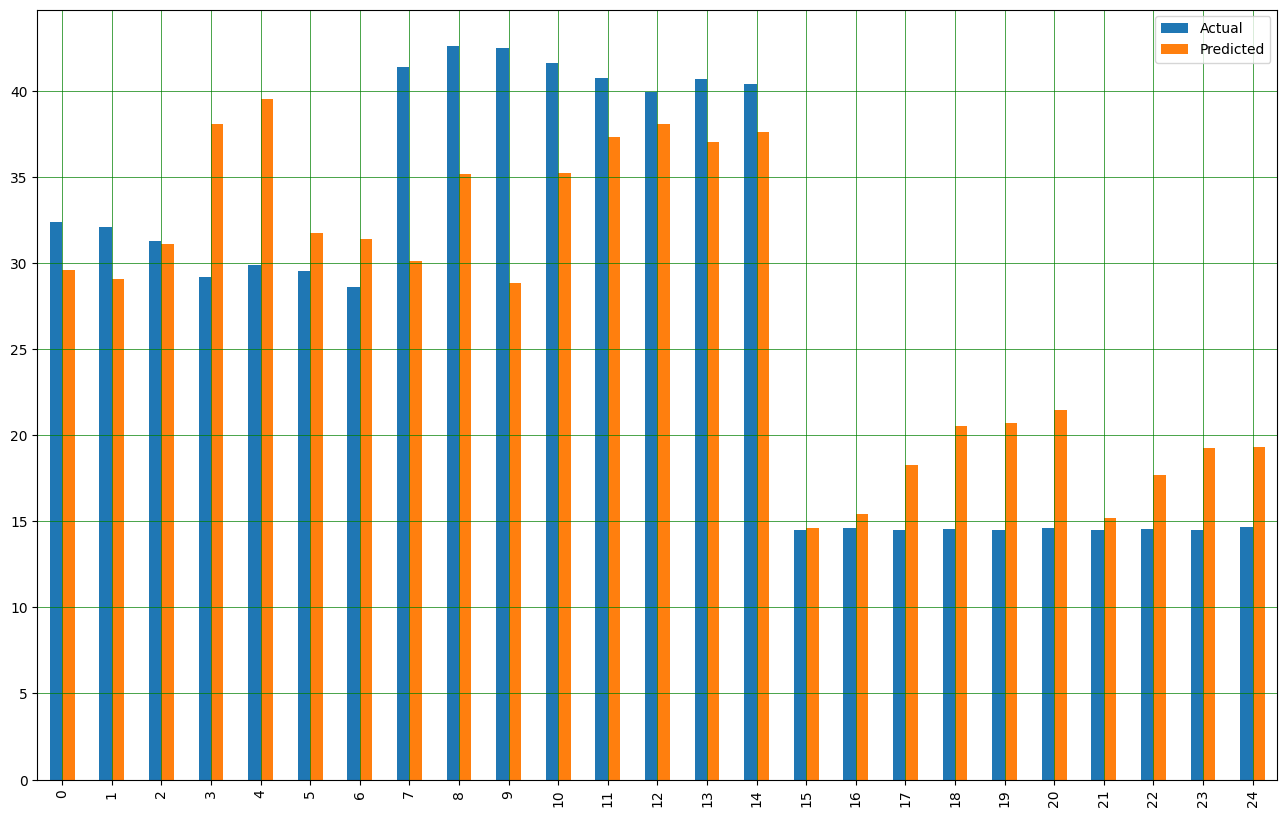

In [86]:
#Plot results
plot_lin_results = lin_result.head(25)
plot_lin_results.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [87]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lin_reg))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lin_reg))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin_reg)))

Mean Absolute Error: 0.4623883303349123
Mean Squared Error: 0.3149249589070094
Root Mean Squared Error: 0.561181752115132


**Dense NN Results**

In [88]:
#Get model predictions
y_pred_nn = nn_model.predict(x_test)
y_pred_nn_inverse = scaler.inverse_transform(y_pred_nn)


nn_results = pd.DataFrame({'Actual': y_test_inverse.flatten(), 'Predicted': y_pred_nn_inverse.flatten()})
print(nn_results)

8/8 [==============================] - 0s 5ms/step
     Actual  Predicted
0     32.39  31.924829
1     32.09  30.873999
2     31.29  32.519257
3     29.22  34.511120
4     29.91  33.257240
..      ...        ...
226   17.88  17.831240
227   16.54  16.738726
228   16.44  20.869114
229   16.48  17.088451
230   16.64  17.131428

[231 rows x 2 columns]


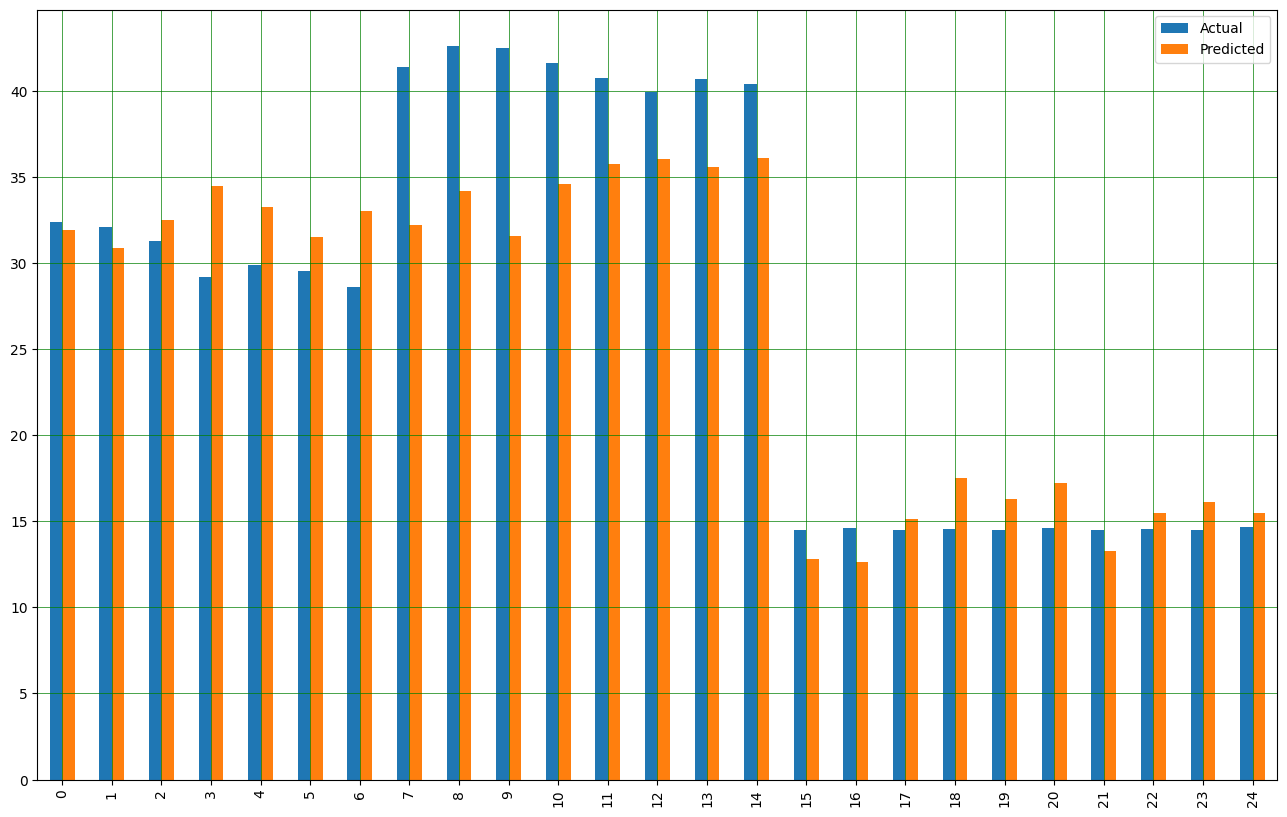

In [89]:
#Plot results
plot_nn_results = nn_results.head(25)
plot_nn_results.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [90]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_nn))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_nn))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_nn)))

Mean Absolute Error: 0.2957816839924713
Mean Squared Error: 0.15719370761658905
Root Mean Squared Error: 0.3964766167336846


**Evaluation**

| MODEL    | AVG MAE | AVG MSE | AVG RMAE |
|----------|---------|---------|----------|
| Linear   | 0.4623  | 0.3149  | 0.5611   |
| Dense NN | 0.2957  | 0.1571  | 0.3964   |

We can see that overall the dense neural network outperformed the linear model in predicting the heating load on unseen test data. The dense model had an average MAE of 0.2957, which was 0.1666 lower than the linear model's average MAE of 0.4623. The dense model also had a lower average MSE of 0.1571 compared to the linear model's average MSE of 0.3149. Furthermore, the dense model's average RMAE of 0.3964 indicated a better overall performance compared to the linear model's RMAE of 0.5611

The superior performance of the dense neural network can be attributed to its ability to capture complex non-linear relationships between input predictors and output labels. Unlike linear models, which are limited to linear relationships, the dense neural network's multiple hidden layers and activation functions enable it to handle non-linearities in the data and adapt to complex patterns.